In [1]:
# Import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Function definitions
# Assigns a source class to the data to allow for referencing of data without splitting dataframe
def assign_source(the_data, sources, idx_start):
  for i, source in enumerate(sources):
    the_data.loc[idx_start[i]:idx_start[i+1]-1, 'source'] = source
  return the_data

## Reproduce the CO2 and temperature anomaly plot in Luthi (2008) [HOLD]

Taking the Luthi Data (composite data) ranging from XX to XX years but substituting teh Bereiter data for the period 612-800 kyr BP which was corrected 

The Bereiter composite data uses the AICC2012 gas age scale whereas Luthi uses EDC3 scale. The temperature anomaly data uses the EDC3 scale, so the Luthi data has been reproduced here with additional data from Law Dome and South Pole covering -51 years to 1797 years



In [3]:
CO2_all_df = pd.read_excel('data/grl52461-sup-0003-supplementary.xls', sheet_name='all records')
CO2_all_df.head(10)

,Dome C (0-22 kyr BP),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Vostok (0-440 kyr BP),Unnamed: 6,Unnamed: 7,Unnamed: 8,Taylor Dome (19-63 kyr BP),...,Unnamed: 98,Unnamed: 99,Unnamed: 100,"EDC (560-806 kyr, corrected for analytical bias)",Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107
0,Monnin et al. (2001+2004),NaN,NaN,NaN,NaN,Petit et al. (1999),NaN,NaN,NaN,Indermühle et al. (2000),...,NaN,NaN,NaN,Bereiter et al. (2014),NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,Pepin et al. (2001),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,Raynaud et al. (2005),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,University of Bern,NaN,NaN,NaN,NaN,LGGE Grenoble,NaN,NaN,NaN,University of Bern,...,NaN,NaN,NaN,University of Bern,NaN,NaN,NaN,NaN,NaN,NaN
5,Depth (m),"Gasage (EDC3, yr BP)","Gasage (AICC2012, yr BP)",CO2 (ppmv),sigma mean CO2 (ppmv),Depth (m),"Gasage (EDC3, yr BP)","Gasage (AICC2012, yr BP)",CO2 (ppmv),Depth (m),...,"Gasage (WDC06A-7, yr BP)",CO2 (ppmv),sigma mean CO2 (ppmv),Depth (m),"Gasage (AICC2012, yr BP)",corrected CO2 (ppmv),analytical sigma mean CO2 (ppmv),Correcting Factor (ppmv),lower bound (2 sigma) of correction F. (ppmv),upper bound (2 sigma) of correction F. (ppmv)
6,102.83,137,350.110103,280.4,1.8,149.1,2690,NaN,284.7,380.82,...,8893.213,267.902828,3.369565,2950.5275,562654.671212,234.065089,0.938515,0,0,0.45076
7,106.89,268,486.6932,274.9,0.7,173.1,3897,3661.9285,272.7,382.42,...,8985.488,265.447325,1.429392,2951.8225,563135.783333,240.114724,2.126252,0,0,0.49078
8,107.2,279,501.195,277.9,0.7,177.4,4124,3746.627,268.1,382.76,...,9080.986,268.861214,1.418332,2952.9225,563536.65,242.288114,0.513847,0,0,0.52478
9,110.25,395,539.649455,279.1,1.3,228.6,6735,6449.176,262.2,383.54,...,9176.945,263.952432,1.853741,2954.0225,563928.766667,245.694323,1.769919,0,0,0.55879


In [4]:
CO2_comp_df = pd.read_excel('data/grl52461-sup-0003-supplementary.xls', sheet_name='CO2 Composite')
# Save the header info
CO2_comp_df_header = CO2_comp_df.iloc[:11]
# Drop the header and assign column names
CO2_comp_df.drop(CO2_comp_df.index[:14], inplace=True)
CO2_comp_df.columns=['Gasage (yr BP)', 'CO2 (ppmv)', 'sigma mean CO2 (ppmv)']


In [5]:
CO2_comp_df.reset_index(drop=True, inplace=True)

In [6]:
sources = CO2_comp_df_header.iloc[:11, 1]
sources = sources.values.tolist()
# Define the index start from the excel where the data is colour coded
idx_start = [0, 248, 253, 348, 638, 833, 911, 1005, 1077, 1301, 1591, 1917]
# Add source column
CO2_comp_df['source'] = ''
CO2_comp_df = assign_source(CO2_comp_df, sources, idx_start)
CO2_comp_df.to_csv("test/co2_comp.csv")

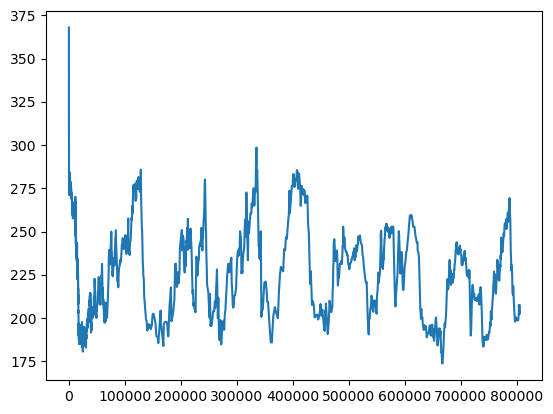

In [7]:
plt.plot(CO2_comp_df['Gasage (yr BP)'],CO2_comp_df['CO2 (ppmv)'])
plt.show()

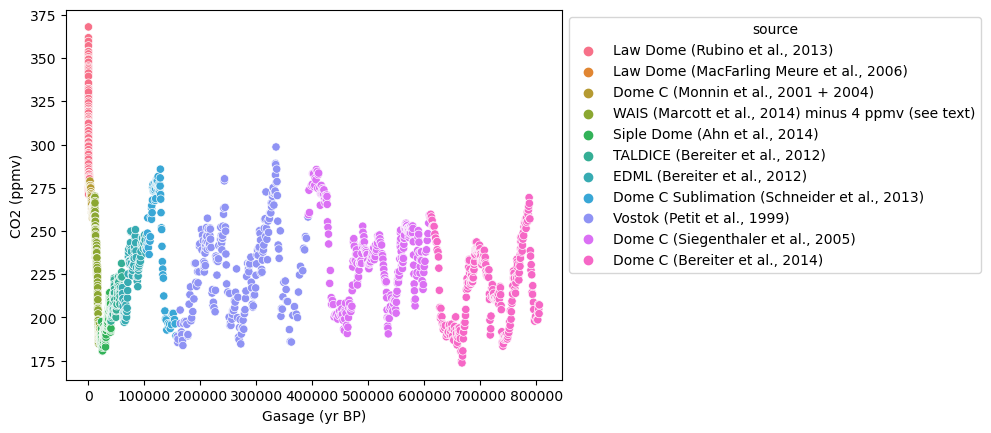

In [8]:
ax = sns.scatterplot(data=CO2_comp_df, x='Gasage (yr BP)', y='CO2 (ppmv)', hue='source')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [9]:
# Read in Luthi Composite Data [x] 
CO2_luthi_comp = pd.read_excel('data/41586_2008_BFnature06949_MOESM31_ESM.xls', sheet_name='3.  Composite CO2')
CO2_luthi_comp.head(10)

,Composite CO2 record (0-800 kyr BP),Unnamed: 1
0,0-22 kyr BP:,Dome C (Monnin et al. 2001) measured at Univer...
1,22-393 kyr BP:,Vostok (Petit et al. 1999; Pepin et al. 2001; ...
2,393-416 kyr BP:,Dome C (Siegenthaler et al. 2005) measured at ...
3,416-664 kyr BP:,Dome C (Siegenthaler et al. 2005) measured at...
4,664-800 kyr BP:,Dome C (Luethi et al. (sub)) measured at Unive...
5,EDC3_gas_a (yr),CO2 (ppmv)
6,137,280.4
7,268,274.9
8,279,277.9
9,395,279.1


In [10]:
CO2_luthi_comp.drop(CO2_luthi_comp.index[:6], inplace=True)
CO2_luthi_comp.columns=['EDC3_gas_a (yr)', 'CO2 (ppmv)']
CO2_luthi_comp.reset_index(drop=True, inplace=True)


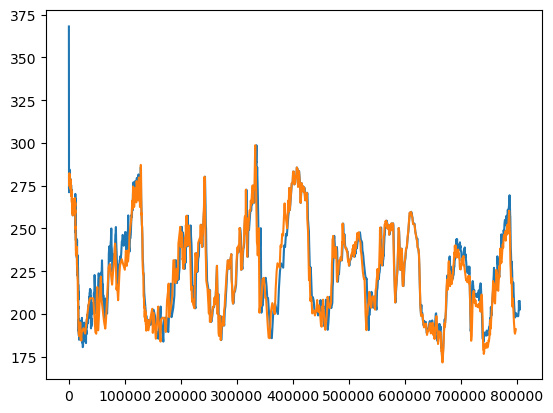

In [11]:
sources_luthi_c = ['Dome C (Monnin et al. 2001) Bern', 'Vostok (Petit et al. 1999; Pepin et al. 2001; Raynaud et al. 2005) LGGE', 'Dome C (Siegenthaler et al. 2005) LGGE', 
                   'Dome C (Siegenthaler et al. 2005) Bern', 'Dome C (Luethi et al. (sub)) Bern']
idx_luthi_c = [0, 183, 517, 537, 867, 1096]
CO2_luthi_comp['source'] = ''
CO2_luthi_comp = assign_source(CO2_luthi_comp, sources_luthi_c, idx_luthi_c)

# plot the data from the Bereiter supplementary data (composite) and the original Luthi data (composite)
plt.plot(CO2_comp_df['Gasage (yr BP)'],CO2_comp_df['CO2 (ppmv)'])
plt.plot(CO2_luthi_comp['EDC3_gas_a (yr)'],CO2_luthi_comp['CO2 (ppmv)'])
plt.show()



In [12]:
CO2_luthi_comp

,EDC3_gas_a (yr),CO2 (ppmv),source
0,137,280.4,Dome C (Monnin et al. 2001) Bern
1,268,274.9,Dome C (Monnin et al. 2001) Bern
2,279,277.9,Dome C (Monnin et al. 2001) Bern
3,395,279.1,Dome C (Monnin et al. 2001) Bern
4,404,281.9,Dome C (Monnin et al. 2001) Bern
...,...,...,...
1091,794608,199.4,Dome C (Luethi et al. (sub)) Bern
1092,795202,195.2,Dome C (Luethi et al. (sub)) Bern
1093,796467,189.3,Dome C (Luethi et al. (sub)) Bern
1094,797099,188.4,Dome C (Luethi et al. (sub)) Bern


In [ ]:
# Take Luthi's data and replace from 611 kyr BP with Bereither's data 
# Also, take the most recent data from Bereither and add to Luthi


In [28]:
# Read in the temperature data 
temp_anom = pd.read_csv('data/edc3deuttemp2007.txt', delim_whitespace=True, skiprows=91)
temp_anom.head(10)

,Bag,ztop,Age,Deuterium,Temperature
0,1,0.00,-50.00000,NaN,NaN
1,2,0.55,-43.54769,NaN,NaN
2,3,1.10,-37.41829,NaN,NaN
3,4,1.65,-31.61153,NaN,NaN
4,5,2.20,-24.51395,NaN,NaN
5,6,2.75,-17.73776,NaN,NaN
6,7,3.30,-10.95945,NaN,NaN
7,8,3.85,-3.20879,NaN,NaN
8,9,4.40,5.48176,NaN,NaN
9,10,4.95,13.52038,NaN,NaN


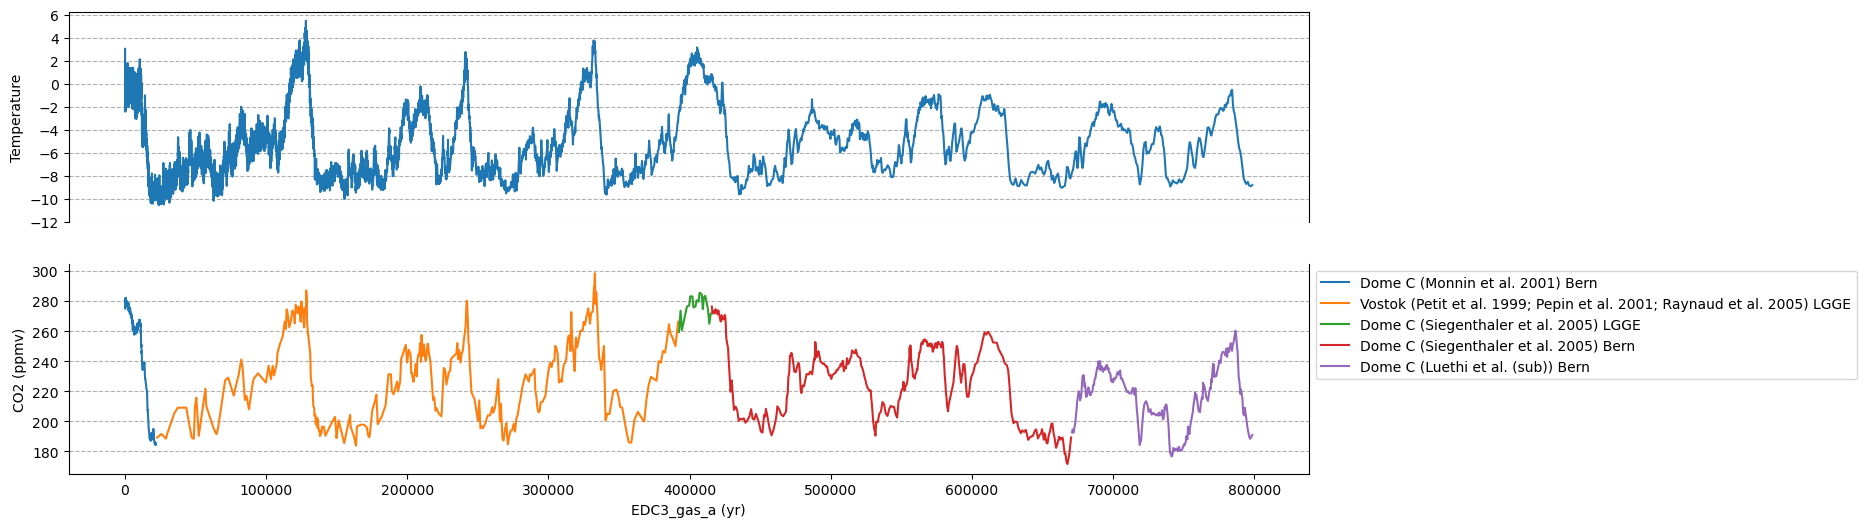

In [66]:
#plt.plot(temp_anom['Age'], temp_anom['Temperature'])
#plt.show()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(16, 6))

sns.lineplot(data=CO2_luthi_comp,  x='EDC3_gas_a (yr)', y='CO2 (ppmv)', ax=ax2, hue='source')
#ax2 = plt.gca().twinx()

sns.lineplot(data=temp_anom, x='Age', y='Temperature', ax=ax1)

ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.xaxis.set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.xaxis.set_visible(False)
#ax2.set_ylim(-100, 6)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.yaxis.grid(True, linestyle='--')
ax2.yaxis.grid(True, linestyle='--')
ax1.set_yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4, 6])
#plt.tight_layout()
plt.show()